In [1]:
import pandas as pd 
import geopandas as gpd 
import os 
import sys
import glob
from shapely import unary_union
import torch
import numpy as np 
import pickle
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

FOLDER_PATH = '../../../../data/rrochas/prediction_validation' 
save_path = f"{FOLDER_PATH}/POIs"
PATH_iris = f'{FOLDER_PATH}/lyon_iris_shapefile'


## Load Time-Serie of a POI :
we have to define : 
- app  (['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest'])
- transfer_mode (['DL','UL'])
- tag   (['park','university','stadium','shop','nightclub','station'])

,69837,69838,69839,70124,70125,70126,70411,70412,70413
2019-03-16 00:00:00,61558.0,51913.0,36852.0,61742.0,45718.0,32403.0,59299.0,39548.0,29770.0
2019-03-16 00:15:00,149082.0,103979.0,51959.0,146765.0,96006.0,43552.0,121719.0,74265.0,38763.0
2019-03-16 00:30:00,82022.0,61609.0,38569.0,87722.0,62556.0,36515.0,81148.0,54888.0,36612.0
2019-03-16 00:45:00,109283.0,74286.0,33663.0,109101.0,68626.0,28229.0,89395.0,51159.0,23432.0
2019-03-16 01:00:00,56564.0,54622.0,42245.0,51379.0,42503.0,35651.0,47279.0,34524.0,28922.0


<Axes: >

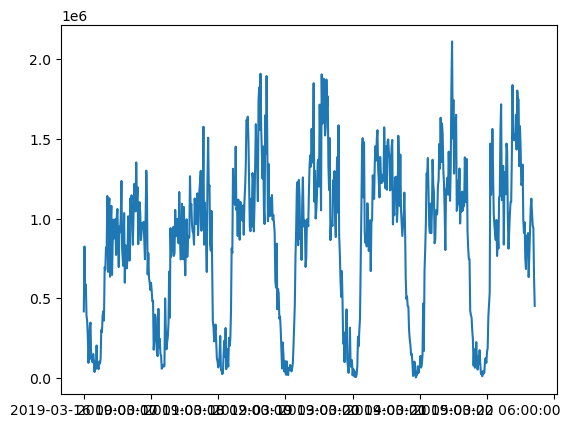

In [12]:
app = 'Instagram'
transfer_mode = 'DL'
tag = 'park'
expanded = '' # _expanded 

list_netmob_POI_paths = glob.glob(f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/{tag}/{app}/*_{transfer_mode}.csv")
path = list_netmob_POI_paths[0]
osmid = path.split('/')[-1][3:-7]
df = pd.read_csv(path,index_col = 0)
display(df.head())
df.sum(axis=1).iloc[:96*7].plot()

### Localise the POI: 

name:  Parc de la Cerisaie
geometry: 


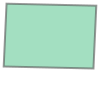

number of tile-ids:  9


In [13]:
gdf_POI_2_tile_ids = gpd.read_file(f"{save_path}/gdf_POI_2_tile_ids.geojson")
gdf_POI_2_tile_ids.tile_ids = gdf_POI_2_tile_ids.tile_ids.apply(lambda str_tile_id: list(map(int,str_tile_id.split(','))))
gdf_POI_2_tile_ids.geometry =  gdf_POI_2_tile_ids.geometry.apply(lambda multipoly : unary_union(multipoly))

gdf_POI_i = gdf_POI_2_tile_ids[(gdf_POI_2_tile_ids['id'] == osmid) &
                   (gdf_POI_2_tile_ids['type'] == f"POI{expanded}")
                   ]
print('name: ',gdf_POI_i.name.values[0])
print('geometry: ')
display(gdf_POI_i.geometry.values[0])
print('number of tile-ids: ',len(gdf_POI_i.tile_ids.values[0]))

## Associate POI to Spatial unit : 

In [14]:
stations = gdf_POI_2_tile_ids[gdf_POI_2_tile_ids['type'] == 'station'].to_crs('epsg:4326')
stations['geometry'] = stations['geometry'].centroid

/tmp/ipykernel_89084/716454905.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations['geometry'] = stations['geometry'].centroid


In [15]:
def find_closest(row, gdf1):
    distances = gdf1.geometry.distance(row.geometry.exterior)
    closest_index = distances.idxmin()
    return closest_index

# Create a new column in gdf2 to store the index of the closest gdf1 geometry
gdf2_with_closest = gdf_POI_2_tile_ids.copy()
gdf2_with_closest['closest_index'] = gdf2_with_closest.apply(find_closest, axis=1, gdf1=stations)

# Merge with stations : 
gdf2_with_closest = gdf2_with_closest.merge(stations[['id','geometry']], left_on='closest_index',right_index = True, suffixes=('', '_closest'))
gdf2_with_closest = gdf2_with_closest.drop(columns = ['closest_index'])
gdf2_with_closest.explore(('id_closest'))

/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs

/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf1.geometry.distance(row.geometry.exterior)
/tmp/ipykernel_89084/3107411218.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs

In [16]:
stations_expanded = gdf2_with_closest[gdf2_with_closest['type'] == 'station_expanded']
stations = gdf2_with_closest[gdf2_with_closest['type'] == 'station']

POIs = gdf2_with_closest[gdf2_with_closest['type'] == 'POI']
POIs_expanded = gdf2_with_closest[gdf2_with_closest['type'] == 'POI_expanded']

In [19]:
def get_POI_Time_Serie(osmid,tag,app,transfer_mode,expanded):
    path_df = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/{tag}/{app}/df_{osmid}_{transfer_mode}.csv"
    time_serie = pd.read_csv(path_df,index_col = 0).sum(axis=1)
    return(time_serie)

def run_init(apps,id_station,expanded,transfer_modes):
    # INIT metadata and save folder for each app:
    metadata = {'apps':apps,
                'id_station':id_station,
                'expanded':expanded,
                'transfer_modes':transfer_modes,
                'shape': '[len(apps),len(osmid),len(transfer_modes),len(dates)]'
                }
    
    save_folder0 = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/Inputs"
    save_folder = f"{save_folder0}/{id_station}"
    if not os.path.exists(save_folder0):
        os.mkdir(save_folder0)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    print(id_station)
    return(metadata,save_folder)

def get_list_osmid(id_station,expanded):
    # Init the research by looking at the subway station : 
    list_assigned_osmid = [id_station]
    list_tag_osmid = ['station']
    # Get the POI ids and tag associated to the subway station : 
    gdf = globals()[f"POIs{expanded}"]
    list_assigned_osmid = list_assigned_osmid+list(gdf[gdf['id_closest'] == id_station]['id'])
    list_tag_osmid = list_tag_osmid+list(gdf[gdf['id_closest'] == id_station]['tag'])
    return list_assigned_osmid,list_tag_osmid

def build_npy_for_each_spatial_unit(apps,id_stations,expanded,transfer_modes):
    for id_station in id_stations:
        ## INIT
        (metadata,save_folder) = run_init(apps,id_station,expanded,transfer_modes)
        list_assigned_osmid,list_tag_osmid = get_list_osmid(id_station,expanded)
        # __Update metadata:
        metadata.update({'osmid':list_assigned_osmid,
                                'tags':list_tag_osmid})
        ## ------------------------

        List_tensor_apps = []
        # Build Tensor of the NetMob TimeSerie associated to a spatial unit (subway station):
        for app in apps:

            # Tackle Tile-ids around station : 
            List_tensor_osmid = []
            for osmid,tag in zip(list_assigned_osmid,list_tag_osmid):
                List_time_series = []
                ## Tackle transfer modes: 
                for transfer_mode in transfer_modes:
                    time_serie =get_POI_Time_Serie(osmid,tag,app,transfer_mode,expanded).sort_index()  # Be sure index are ordered in an ascending manner
                    List_time_series.append(time_serie.values)
                # ---> Torch.Tensor size :[2,len(dates)] torch.Tensor  (or convert into [1,len(dates)] if only one transfer-mode is considered
                T_transfer = torch.Tensor(np.array(List_time_series))
                List_tensor_osmid.append(T_transfer)

            # ---> Torch.Tensor size : [len(POIs associated to station i) + 1,2,len(dates)]
            T_osmids_around_station = torch.stack(List_tensor_osmid)
            List_tensor_apps.append(T_osmids_around_station)

        metadata.update({'dates':time_serie.index})
        T_apps_on_station_i = torch.stack(List_tensor_apps)
        # Save NetMob Tensor and the MetaData:
        np.save(open(f"{save_folder}/data.npy","wb"),T_apps_on_station_i.numpy())
        pickle.dump(metadata,open(f"{save_folder}/metadata.pkl","wb"))


id_stations = list(stations['id'].unique())
tags = ['park','stadium','university','shop','nightclub']
apps = ['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest']
transfer_modes = ['DL','UL'] # ['DL'] # ['UL'], # ['DL','UL']
expanded = '_expanded' # '_expanded'  # ''
# Get set of time-serie For each Spatial-Unit

if False: 
    build_npy_for_each_spatial_unit(apps,id_stations,expanded,transfer_modes)


# Load saved data at a specific app:

In [2]:
id_station = 'CHA'   #CHARPENNES
expanded = '' # _expanded 
save_folder = f"{FOLDER_PATH}/POIs/netmob_POI_Lyon{expanded}/Inputs/{id_station}"
data_app = np.load(open(f"{save_folder}/data.npy","rb"))
metadata = pickle.load(open(f"{save_folder}/metadata.pkl","rb"))

### Mauvais chemin de sauvegarde la première fois, besoin de déplacer certains fichier.

In [2]:
if False:
    import shutil
    from load_inputs.subway_in import get_trigram_correspondance
    POI_path = '../../../../data/rrochas/prediction_validation/POIs'
    apps = ['Instagram','Facebook','Uber','Google_Maps','Waze','Spotify','Deezer','Telegram','Facebook_Messenger','Snapchat','WhatsApp','Twitter', 'Pinterest']

    for expanded in ['','_expanded']:
        new_folder_path = f'{POI_path}/netmob_POI_Lyon{expanded}/station'
        if not os.path.exists(new_folder_path):
            os.mkdir(new_folder_path)
        for app in apps:
            new_folder_path_app = f'{new_folder_path}/{app}'
            if not os.path.exists(new_folder_path_app):
                os.mkdir(new_folder_path_app)
            
            current_folder_path= f'{POI_path}/netmob_POI_Lyon{expanded}/nightclub/{app}'

            list_csv_path = glob.glob(f"{current_folder_path}/*")
            for k,file_path in enumerate(list_csv_path) :
                tag_id = file_path.split('/')[-1][3:-7]
                if tag_id in list(get_trigram_correspondance().COD_TRG):
                    shutil.move(file_path, new_folder_path_app)  # mv file_path new_folder_path_app

# Test Load NetMob POI dans le framework : 

In [3]:
# GET PARAMETERS
import sys
import os
import pandas as pd

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from examples.benchmark import local_get_args,get_inputs,get_trial_id


def get_ds(model_name,dataset_names,dataset_for_coverage,vision_model_name = None):
    save_folder = None
    df_loss,df_results = pd.DataFrame(),pd.DataFrame()
    modification = {'epochs' : 10, #100,
                    }

    # Tricky but here we net to set 'netmob' so that we will use the same period for every combination
    args,folds,hp_tuning_on_first_fold = local_get_args(model_name,
                                                            dataset_names=dataset_names,
                                                            dataset_for_coverage=dataset_for_coverage,
                                                            modification = modification)
    trial_id = get_trial_id(args,vision_model_name=vision_model_name)
    K_fold_splitter,K_subway_ds,dic_class2rpz = get_inputs(args,vision_model_name,folds)
    ds = K_subway_ds[0]
    return(ds,args,trial_id,save_folder,dic_class2rpz,df_loss)

dataset_names = ["subway_in","netmob_POIs"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['netmob_POIs'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'
vision_model_name =  'ImageAvgPooling'

ds,args,trial_id,save_folder,dic_class2rpz,df_loss = get_ds(model_name,dataset_names,dataset_for_coverage,vision_model_name=vision_model_name)

Training and Hyper-parameter tuning with Ray is not possible
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6815, 40, 7]) Utarget size:  torch.Size([6815, 40, 1])
U_train size:  torch.Size([4089, 40, 7]) Utarget_train size:  torch.Size([4089, 40, 1])
U_valid size:  torch.Size([1363, 40, 7]) Utarget_valid size:  torch.Size([1363, 40, 1])
U_test size:  torch.Size([1362, 40, 7]) Utarget_test size:  torch.Size([1362, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1774.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 4])
tensor size:  torch.Size([4, 4])
mean_values repeated:  torch.Size([4, 4])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6815, 4, 7]) Utarget size:  torch.

In [6]:
from load_inputs.subway_in import get_trigram_correspondance

position_station = ds.contextual_positions['netmob_POIs']
LIST_COD_TRG = list(get_trigram_correspondance().COD_TRG)  # Associated list. position_station[k] correspond to LIST_COD_TRG[k]

ds.contextual_tensors['netmob_CHA']['train'].size()

torch.Size([1715, 12, 7])

# Sélection de l'information contenue dans les POIs, encodage, ajout dans le modèle
## Inspiration
### TFT:
- Contient des bloocs de 'Variable Selection' pour chaque Input à l'instant 't'. Que ce soit pour 'static', pour 'past time-depend input' (known ou unknown) ou pour 'futur' (known) 
    - On transform les inputs (Linear ou Embedding si categorical)
    - On passe dans un GRN (Gated Residual Network), un Gating Mechanism:
        - $GRN(X,X_c) = LayerNorm(X + GLU(\eta{_1}))$
        - $GLU(\eta) =\sigma(W_{4}\eta + b_{4})\odot (W_{5}\eta + b_{5})$
        - $\eta{_1} = W_{1}*\eta_{2} + b_{1},  \in\mathbb{R}^{d_{model}}$
        - $\eta{_2} =ELU(W_{2}*X + W_{3}*X_{c} + b_{2})\in\mathbb{R}^{d_{model}}$
        - $W_{i}\in \mathbb{R}^{d_{model}\times d_{model}}$
        - $\odot$ element wise hadamard product  

        - $ELU$ : Exponentil Linear Unit activation function 
    - On passe dans un gated module (softmax())

In [7]:
#from dl_models.TFT.Variable_selection_network import VariableSelectionNetwork

# Input VariableSelectionNetwork : [B,L,C], où C : nombre de 'past' variables
pos_notmob_POIs= ds.contextual_positions['netmob_POIs']
X,Y,C = next(iter(ds.dataloader['train']))

selected_station = 'CHA'
pos_CHA = [k for k,station in enumerate(LIST_COD_TRG) if station == selected_station][0]

# Shape: [B,C,L]
input_vsn = C[pos_CHA]

In [34]:
from dl_models.VariableSelectionNetwork import VariableSelectionNetwork

# Inputs
station_past_volume = X[:,pos_CHA,:].unsqueeze(1)
station_past_contextual = C[pos_CHA]
# Past inputs associated to 1 station: [B,C,L] : C = 1 + nb_POIs 
past_inputs = torch.cat([station_past_volume,station_past_contextual],dim=1)


#input_vsn = input_vsn.permute(0,2,1)  # [B,C,L] -> [B,L,C]
input_size = past_inputs.size(-1) 
nb_ts = past_inputs.size(-2) 
grn_h_dim = 64
grn_out_dim = 128
contextual_dim = None #No static Variable. Otherwise contextual_dim: int   (surely = 1)
dropout = 0.1

vsn_module = VariableSelectionNetwork(input_size,nb_ts,grn_h_dim,grn_out_dim,contextual_dim,dropout)

# Forward:
output,attn_weighs = vsn_module(past_inputs)
output.size()


intput of grn to get attn weight:  torch.Size([32, 21])
GRN(
  (align): Linear(in_features=21, out_features=3, bias=True)
  (dense1): Linear(in_features=21, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.1, inplace=False)
  (gate): FastGLU(
    (dense): Linear(in_features=3, out_features=6, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer_norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
)
grn of attn weight:  None
attn weight before softmax:  torch.Size([32, 3])
output grn:  torch.Size([32, 3, 128])
attn_weighs:  torch.Size([32, 3])


torch.Size([32, 128])